#### Anushka

# Distance Feature Significance Exploration 

#### Reading in the data

In [1]:
import pandas as pd
data = pd.read_parquet("../data/curated/final_train_hospital_cbd_dist_data")
data.head()

In [36]:
data.columns

Index(['url', 'price', 'address', 'property_type', 'latitude', 'longitude',
       'Beds', 'Baths', 'Parking', 'bond', 'extracted_price', 'geometry',
       'index_right', 'sa2_code', 'sa2_name', 'chg_flag', 'chg_lbl',
       'sa3_code', 'sa3_name', 'sa4_code', 'sa4_name', 'gcc_code', 'gcc_name',
       'ste_code', 'ste_name', 'aus_code', 'aus_name', 'areasqkm', 'loci_uri',
       'geometry_proj', 'suburb', 'property_id', 'nearest_station_id',
       'train_station_distance_km', 'cbd_distance_km', 'nearest_hospital_id',
       'nearest_hospital_distance'],
      dtype='object')

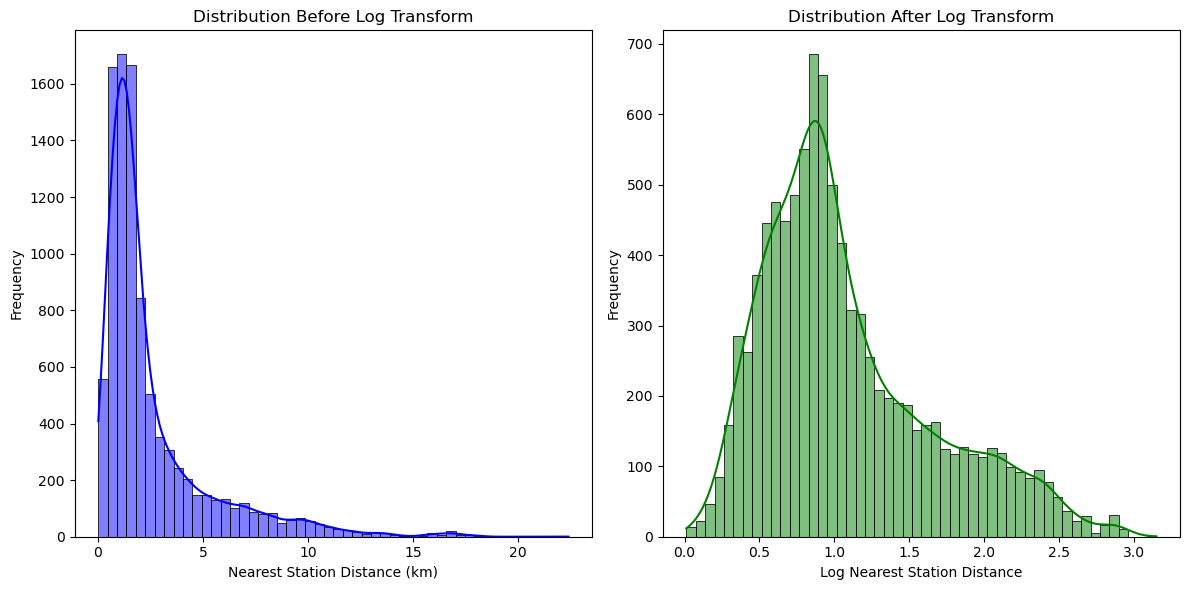

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = data.copy()

plt.figure(figsize=(12, 6))

# Distribution before log transform with KDE
plt.subplot(1, 2, 1)
sns.histplot(df['train_station_distance_km'], bins=50, kde=True, color='blue')
plt.title('Distribution Before Log Transform')
plt.xlabel('Nearest Station Distance (km)')
plt.ylabel('Frequency')

# Apply log transformation (log1p to handle values of 0)
df['log_nearest_station_distance'] = df['train_station_distance_km'].apply(lambda x: np.log1p(x))

# Distribution after log transform with KDE
plt.subplot(1, 2, 2)
sns.histplot(df['log_nearest_station_distance'], bins=50, kde=True, color='green')
plt.title('Distribution After Log Transform')
plt.xlabel('Log Nearest Station Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


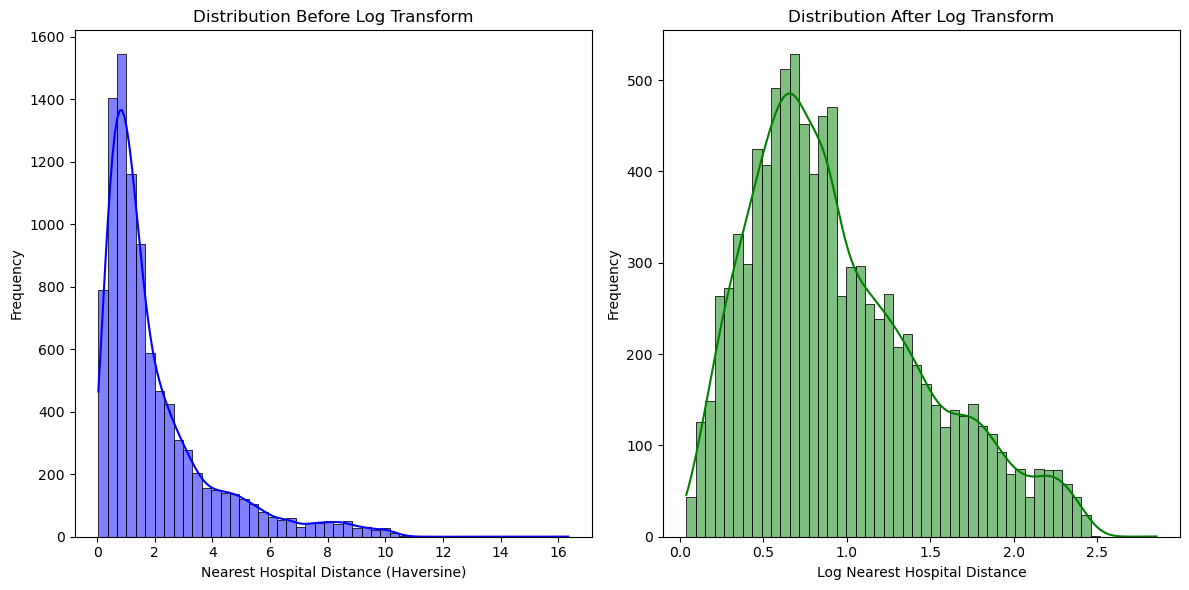

In [40]:
plt.figure(figsize=(12, 6))

# Distribution before log transform with KDE
plt.subplot(1, 2, 1)
sns.histplot(df['nearest_hospital_distance'], bins=50, kde=True, color='blue')
plt.title('Distribution Before Log Transform')
plt.xlabel('Nearest Hospital Distance (Haversine)')
plt.ylabel('Frequency')

# Distribution after log transform with KDE
df['log_nearest_hospital_distance'] = df['nearest_hospital_distance'].apply(lambda x: np.log1p(x))
plt.subplot(1, 2, 2)
sns.histplot(df['log_nearest_hospital_distance'], bins=50, kde=True, color='green')
plt.title('Distribution After Log Transform')
plt.xlabel('Log Nearest Hospital Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Calculating outliers for weekly rent prices

In [41]:
Q1 = df['extracted_price'].quantile(0.25)
Q3 = df['extracted_price'].quantile(0.75)
IQR = Q3 - Q1

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")

Q1 (25th percentile): 500.0
Q3 (75th percentile): 720.0
IQR: 220.0
Lower Bound for Outliers: 170.0
Upper Bound for Outliers: 1050.0


#### Filtering out outliers

In [42]:
filtered_df = df[(df['extracted_price'] >= lower_bound) & (df['extracted_price'] <= upper_bound)]

print(f"Original DataFrame size: {df.shape}")
print(f"Filtered DataFrame size: {filtered_df.shape}")

Original DataFrame size: (9565, 39)
Filtered DataFrame size: (8906, 39)


#### Dropping any null values before correlation analysis

In [43]:
initial_row_count = len(filtered_df)
print(f"Initial number of rows: {initial_row_count}")

Initial number of rows: 8906


In [44]:
# Drop rows where any of the specified columns have null values
df_cleaned = filtered_df.dropna(subset=['nearest_hospital_distance', 'extracted_price', 'cbd_distance_km', 'train_station_distance_km'])

# Count rows after dropping nulls
final_row_count = len(df_cleaned)
print(f"Number of rows after dropping nulls: {final_row_count}")


Number of rows after dropping nulls: 8904


In [45]:
rows_dropped = initial_row_count - final_row_count
print(f"Number of rows dropped: {rows_dropped}")


Number of rows dropped: 2


#### Boxplots to show effect of dropping outliers

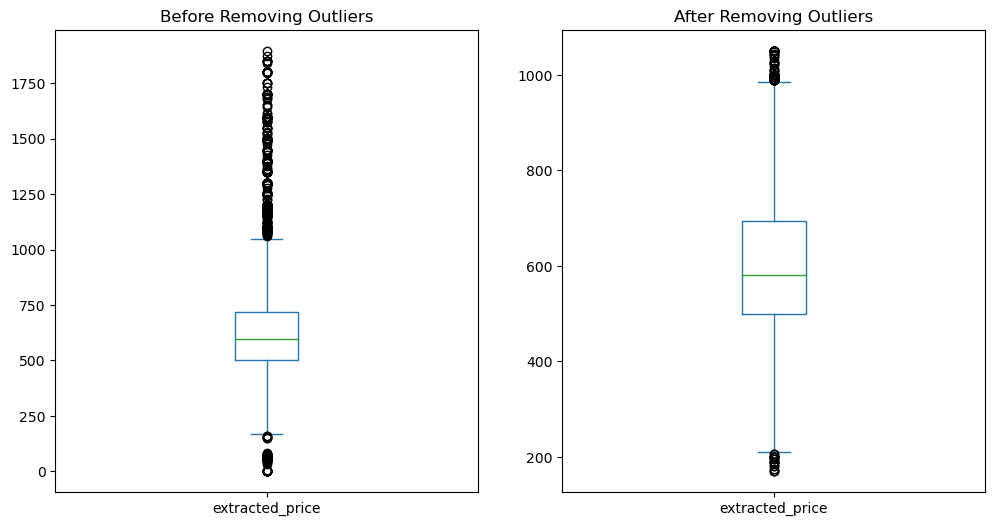

In [46]:
import matplotlib.pyplot as plt

# Plot before and after removing outliers
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

df['extracted_price'].plot(kind='box', ax=ax[0], title='Before Removing Outliers')
filtered_df['extracted_price'].plot(kind='box', ax=ax[1], title='After Removing Outliers')

plt.show()


#### Correlation analysis

 Pearson correlation is low for all distance features, potentially implying that relationship is not linear (evident from graphs). However, the p-values show that these features are statistically significant (more so that the result is unlikely to have arisen by chance alone).

In [62]:
df_cleaned['log_cbd_distance'] = df_cleaned['cbd_distance_km'].apply(lambda x: np.log1p(x))

/var/folders/9c/2vbsxdnd7k7_tnzhl33znmpm0000gp/T/ipykernel_94556/2614011426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['log_cbd_distance'] = df_cleaned['cbd_distance_km'].apply(lambda x: np.log1p(x))


,url,price,address,property_type,latitude,longitude,Beds,Baths,Parking,bond,...,suburb,property_id,nearest_station_id,train_station_distance_km,cbd_distance_km,nearest_hospital_id,nearest_hospital_distance,log_nearest_station_distance,log_nearest_hospital_distance,log_cbd_distance
1,https://www.domain.com.au/10-51-55-leslie-stre...,$500 Per Week,"10/51-55 Leslie Street, Donvale VIC 3111",Apartment / Unit / Flat,-37.781431,145.181474,2.0,1.0,1.0,2173.0,...,Donvale,7,19900,4.6923,24.88939,H5063,1.272015,1.739114,0.820667,3.253833
2,https://www.domain.com.au/293-richardson-stree...,$630.00,"293 Richardson Street, Carlton North VIC 3054",House,-37.784081,144.965615,2.0,1.0,0.0,2738.0,...,Carlton North,19,19969,1.4377,4.14098,H0372,1.651170,0.891055,0.975001,1.637244
3,https://www.domain.com.au/786-drummond-street-...,$720.00,"786 Drummond Street, Carlton North VIC 3054",House,-37.786146,144.971258,3.0,1.0,0.0,3129.0,...,Carlton North,22,19969,2.2956,4.03091,H0381,1.577533,1.192588,0.946833,1.615601
4,https://www.domain.com.au/8-1068-lygon-street-...,$750 pw,"8/1068 Lygon Street, Carlton North VIC 3054",Apartment / Unit / Flat,-37.780942,144.970534,3.0,2.0,2.0,3260.0,...,Carlton North,26,19969,1.7662,4.22506,H0372,1.990258,1.017475,1.095360,1.653466
5,https://www.domain.com.au/1-28-queens-parade-g...,$550 pw,"1/28 Queens Parade, Glen Iris VIC 3146",Apartment / Unit / Flat,-37.852446,145.092061,3.0,1.0,1.0,2390.0,...,Glen Iris,29,19849,1.6396,15.10733,H5383,0.520346,0.970627,0.418938,2.779274
7,https://www.domain.com.au/4-1508-malvern-road-...,$645.00,"4/1508 Malvern Road, Glen Iris VIC 3146",Apartment / Unit / Flat,-37.854472,145.048490,2.0,1.0,1.0,2803.0,...,Glen Iris,50,19912,0.4065,12.34697,H5073,1.066565,0.341104,0.725888,2.591289
8,https://www.domain.com.au/1490-high-street-gle...,$1000 per week,"1490 High Street, Glen Iris VIC 3146",House,-37.858791,145.045013,3.0,1.0,2.0,4345.0,...,Glen Iris,54,19912,1.3080,12.30030,H5030,1.059285,0.836381,0.722359,2.587787
9,https://www.domain.com.au/3-5-estella-street-g...,$650.00,"3/5 Estella Street, Glen Iris VIC 3146",Apartment / Unit / Flat,-37.862403,145.063736,2.0,1.0,1.0,2824.0,...,Glen Iris,57,19837,0.8074,13.40448,H5073,1.966632,0.591889,1.087427,2.667539
10,https://www.domain.com.au/102-288-tooronga-roa...,Stay 1 mth plus - $950pw,"102/288 Tooronga Road, Glen Iris VIC 3146",Apartment / Unit / Flat,-37.852672,145.042465,2.0,1.0,1.0,4128.0,...,Glen Iris,65,19911,0.4622,11.33806,H5408,1.048885,0.379942,0.717296,2.512689
12,https://www.domain.com.au/7-39-47-peel-street-...,$650.00,"7/39-47 Peel Street, West Melbourne VIC 3003",Apartment / Unit / Flat,-37.807171,144.955434,2.0,1.0,1.0,NaN,...,West Melbourne,94,19841,0.7544,1.60972,H0384,0.745274,0.562127,0.556912,0.959243


In [66]:
# check correlation to different types of properties for extracted price
df_cleaned.groupby('property_type')[['log_cbd_distance', 'extracted_price']].corr()

log_cbd_distance  \
property_type                                                      
Apartment / Unit / Flat       log_cbd_distance          1.000000   
                              extracted_price          -0.347144   
Carspace                      log_cbd_distance          1.000000   
                              extracted_price           0.502540   
Duplex                        log_cbd_distance          1.000000   
                              extracted_price          -1.000000   
House                         log_cbd_distance          1.000000   
                              extracted_price          -0.355330   
New Apartments / Off the Plan log_cbd_distance          1.000000   
                              extracted_price           0.430133   
New House & Land              log_cbd_distance          1.000000   
                              extracted_price          -0.880681   
Semi-Detached                 log_cbd_distance          1.000000   
                              extracted_price          -0.973684   
Studio                        log_cbd_distance          1.000000   
                              extracted_price          -0.483891   
Terrace                       log_cbd_distance          1.000000   
                              extracted_price           0.347777   
Townhouse                     log_cbd_distance          1.000000   
                              extracted_price          -0.267778   
Villa                         log_cbd_distance          1.000000   
                              extracted_price           0.037109   

                                                extracted_price  
property_type                                                    
Apartment / Unit / Flat       log_cbd_distance        -0.347144  
                              extracted_price          1.000000  
Carspace                      log_cbd_distance         0.502540  
                              extracted_price          1.000000  
Duplex                        log_cbd_distance        -1.000000  
                              extracted_price          1.000000  
House                         log_cbd_distance        -0.355330  
                              extracted_price          1.000000  
New Apartments / Off the Plan log_cbd_distance         0.430133  
                              extracted_price          1.000000  
New House & Land              log_cbd_distance        -0.880681  
                              extracted_price          1.000000  
Semi-Detached                 log_cbd_distance        -0.973684  
                              extracted_price          1.000000  
Studio                        log_cbd_distance        -0.483891  
                              extracted_price          1.000000  
Terrace                       log_cbd_distance         0.347777  
                              extracted_price          1.000000  
Townhouse                     log_cbd_distance        -0.267778  
                              extracted_price          1.000000  
Villa                         log_cbd_distance         0.037109  
                              extracted_price          1.000000

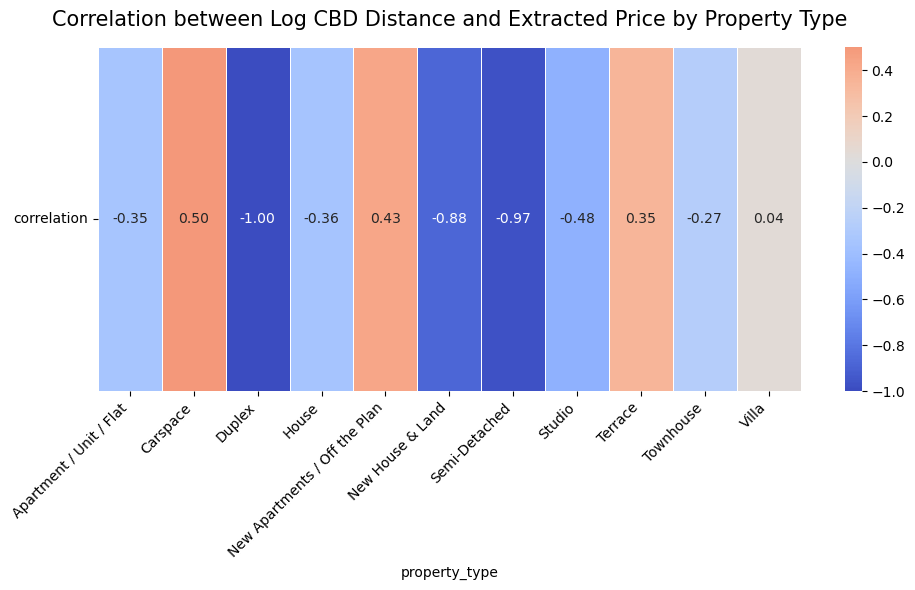

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialise an empty list to store the correlations
correlation_list = []

# Loop through each property type and calculate the correlation
for property_type, group in df_cleaned.groupby('property_type'):
    corr_value = group[['log_cbd_distance', 'extracted_price']].corr().iloc[0, 1]
    correlation_list.append((property_type, corr_value))

# Create a DataFrame from the list of correlations
correlation_df = pd.DataFrame(correlation_list, columns=['property_type', 'correlation'])

# Set the property_type as the index
correlation_df.set_index('property_type', inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df.T, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f", center=0)

# Add titles and labels
plt.title("Correlation between Log CBD Distance and Extracted Price by Property Type", fontsize=15, pad=15)
plt.yticks(rotation=0, fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.show()


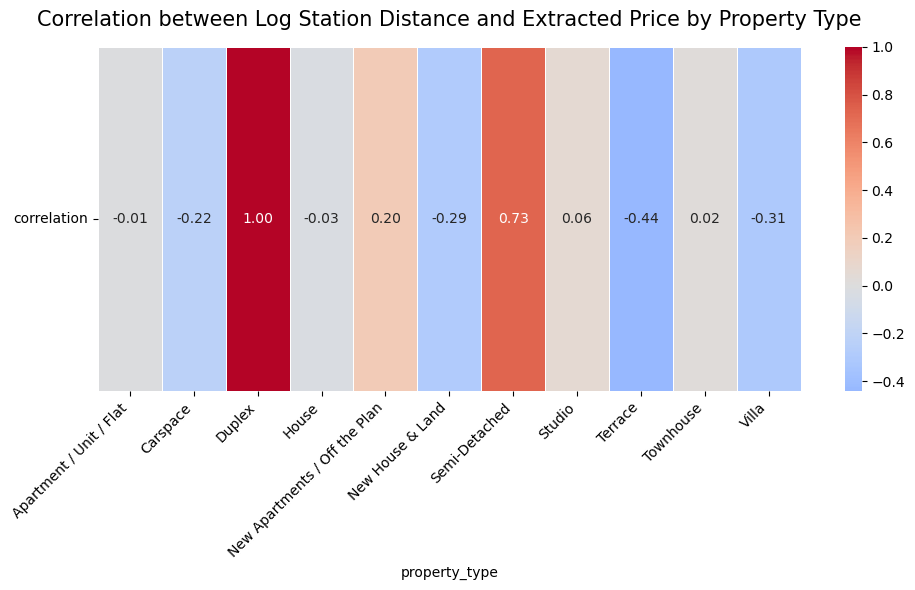

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialise an empty list to store the correlations
correlation_list = []

# Loop through each property type and calculate the correlation
for property_type, group in df_cleaned.groupby('property_type'):
    corr_value = group[['log_nearest_station_distance', 'extracted_price']].corr().iloc[0, 1]
    correlation_list.append((property_type, corr_value))

# Create a DataFrame from the list of correlations
correlation_df = pd.DataFrame(correlation_list, columns=['property_type', 'correlation'])

# Set the property_type as the index
correlation_df.set_index('property_type', inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df.T, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f", center=0)

# Add titles and labels
plt.title("Correlation between Log Station Distance and Extracted Price by Property Type", fontsize=15, pad=15)
plt.yticks(rotation=0, fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.show()


In [79]:
from scipy import stats
import numpy as np


# Assuming `df` is your DataFrame and you have numeric columns for prices and distances
r, p_value = stats.pearsonr(df_cleaned['extracted_price'], df_cleaned['log_cbd_distance'])
print("Correlation Coefficient for Log CBD Distance:", r)
print("P-value for CBD Distance:", p_value)

r_hospital, p_value_hospital = stats.pearsonr(df_cleaned['extracted_price'], df_cleaned['log_nearest_hospital_distance'])
print("Correlation Coefficient for Log Hospital Distance:", r_hospital)
print("P-value for Hospital Distance:", p_value_hospital)

r_train, p_value_train = stats.pearsonr(df_cleaned['extracted_price'], df_cleaned['log_nearest_station_distance'])
print("Correlation Coefficient for Log Nearest Train Station Distance:", r_train)
print("P-value for Nearest Train Station Distance:", p_value_train)


Correlation Coefficient for Log CBD Distance: -0.16215760013031277
P-value for CBD Distance: 1.6056234566876813e-53
Correlation Coefficient for Log Hospital Distance: -0.12608029545401342
P-value for Hospital Distance: 7.056229598973037e-33
Correlation Coefficient for Log Nearest Train Station Distance: -0.013351275052123301
P-value for Nearest Train Station Distance: 0.2077707307430596
